### Step 1: Import packages

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from math import cos, sin, pi
import geopandas as gpd
from shapely.geometry import Polygon
import json
import warnings
warnings.filterwarnings(action="ignore")
from google.cloud import bigquery

### Step 2: Define the global inputs

In [7]:
entity_id = "PY_CL" # Enter the country of interest
city_name = "Santiago" # Enter the city of interest
lookback_period = "DATE_SUB(CURRENT_DATE(), INTERVAL 1 MONTH) AND DATE_SUB(CURRENT_DATE(), INTERVAL 1 DAY)" # One month back

### DON'T CHANGE THESE INPUTS ###
hex_radius_tesellation_m = 500 # The radius of each geospatial Hexagon
zone_st_point_order_share = 0.2 # The order share floor to take a zone's starting point into account when retrieving the scraping points

### Step 3: Retrieve the ESPG code based on the entity_id specified above

In [8]:
# Open the JSON file containing the ESPG codes. The ESPG codes were obtained from ChatGPT
with open(file="country_espg_codes.json", mode="r", encoding="utf-8") as f:
    # Load the data from the JSON file
    espg_codes = json.load(f)

    # Convert espg_codes to a data frame
    df_espg_codes = pd.DataFrame(espg_codes)

    # Close the file
    f.close()

# Retrieve the ESPG code based on the entity_id specified above
crs_espg_code = int(df_espg_codes[df_espg_codes["entity_id"] == entity_id].reset_index(drop=True)["espg_code"][0])

# Print hte ESPG code of the entity
print(f"The ESPG code of {entity_id} is: {crs_espg_code}")

The ESPG code of PY_CL is: 5361


### Step 4: Instantiate a BigQuery client and define the queries to pull geospatial data

In [9]:
# Instantiate the BigQuery client
client = bigquery.Client(project="logistics-customer-staging")

def shape_city_zone(entity_id):
    """
    A function that pulls geospatial data of zones and cities in a target country
    """
    # City shape
    shape_city = client.query(f"""
        WITH city_orders AS (
            SELECT
                entity_id,
                city_id,
                city_name,
                COUNT(DISTINCT platform_order_code) AS city_order_count
            FROM `fulfillment-dwh-production.cl.dps_sessions_mapped_to_orders_v2`
            WHERE TRUE
                AND created_date_local BETWEEN {lookback_period}
                AND is_sent -- Is successful order
                AND entity_id='{entity_id}'
            GROUP BY 1,2,3
        ),

        city_geo_data AS (
            SELECT
                p.entity_id,
                country_name, 
                city.name AS city_name,
                city.id AS city_id,
                city.shape AS city_shape,
                zo.city_order_count,
            FROM `fulfillment-dwh-production.cl.countries`
            LEFT JOIN UNNEST (platforms) AS p
            LEFT JOIN UNNEST (cities) AS city
            LEFT JOIN city_orders AS zo ON zo.entity_id = p.entity_id AND zo.city_id = city.id
            WHERE TRUE
                AND p.entity_id='{entity_id}' -- Filter for a specific entity
                AND city.shape IS NOT NULL -- Remove incorrect geospatial entries
                AND city.is_active -- Active city
                AND zo.city_order_count IS NOT NULL -- Remove cities with zero orders over the last month
        )

        SELECT
            *,
            ROUND(SAFE_DIVIDE(city_order_count, SUM(city_order_count) OVER (PARTITION BY entity_id)), 4) AS city_order_share_of_country
        FROM city_geo_data
    """).to_geodataframe()

    # Zone shapes
    shape_zone = client.query(f"""
        WITH zone_orders AS (
            SELECT
                entity_id,
                city_name,
                city_id,
                zone_name,
                zone_id,
                COUNT(DISTINCT platform_order_code) AS zone_order_count
            FROM `fulfillment-dwh-production.cl.dps_sessions_mapped_to_orders_v2`
            WHERE TRUE
                AND entity_id='{entity_id}'
                AND created_date_local BETWEEN {lookback_period}
                AND is_sent
            GROUP BY 1,2,3,4,5
        ),
        
        zone_geo_data AS (
            SELECT
                p.entity_id,
                country_name, 
                city.name AS city_name,
                city.id AS city_id,
                zone.name AS zone_name,
                zone.id AS zone_id,
                zone.shape AS zone_shape,
                zo_or.zone_order_count,
            FROM `fulfillment-dwh-production.cl.countries`
            LEFT JOIN UNNEST (platforms) AS p
            LEFT JOIN UNNEST (cities) AS city
            LEFT JOIN UNNEST (city.zones) AS zone
            LEFT JOIN zone_orders AS zo_or ON zo_or.entity_id = p.entity_id AND city.id = zo_or.city_id AND zo_or.zone_id = zone.id
            WHERE TRUE
                AND p.entity_id='{entity_id}' -- Filter for a specific entity
                AND zone.shape IS NOT NULL -- Remove incorrect geospatial entries
                AND city.is_active -- Active city
                AND zone.is_active -- Active zone
                AND zo_or.zone_order_count IS NOT NULL -- Remove zones with zero orders
        )

        SELECT
            *,
            ROUND(SAFE_DIVIDE(zone_order_count, SUM(zone_order_count) OVER (PARTITION BY entity_id)), 4) AS zone_order_share_of_country
        FROM zone_geo_data
    """).to_geodataframe()

    return shape_city, shape_zone

# Invoke the function
shape_city, shape_zone = shape_city_zone(entity_id=entity_id)

# Display the coordinate reference system (CRS) information of shape_city
display(shape_city.crs)
print("###---------####---------###")

# Transform the "shape_city" and "shape_zone" GeoDataFrames to the coordinate reference system (CRS) with EPSG code crs_espg_code
shape_city = shape_city.to_crs(crs_espg_code)
shape_zone = shape_zone.to_crs(crs_espg_code)
display(shape_zone.crs) # Would be the same as shape_city.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

###---------####---------###


<Projected CRS: EPSG:5361>
Name: SIRGAS-Chile 2002 / UTM zone 19S
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Chile - 72°W to 66°W, onshore and offshore.
- bounds: (-72.0, -59.87, -66.0, -17.5)
Coordinate Operation:
- name: UTM zone 19S
- method: Transverse Mercator
Datum: SIRGAS-Chile realization 1 epoch 2002
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

### Step 4: Pull each zone's starting point

In [10]:
def zone_starting_point(entity_id):
    """
    A function to retrieve the centroids and orders of the starting points of rider assignment in each zone in a target country

    Definition of demand_distribution from cl.countries:
    The percentage of staffed riders in the starting point in respect to its zone
    
    Example: If 200 riders are staffed in zone 4 and there are 2 starting points with demand distribution 0.25 and 0.75, then 50 (25% of 200) and 150 (75% of 200) of riders should be staffed
    accordingly, and the sum of the demand distribution of all starting points in zone 4 should be one so the absolute demand adds up to 200 again
    """
    # Pull geospatial data about the starting points in the target country
    starting_point_shape = client.query(f"""
        SELECT
            p.entity_id, 
            city.name AS city_name, 
            city.id AS city_id,
            zone.name AS zone_name,
            zone.id AS zone_id,
            sp.name AS sp_name,
            sp.id AS sp_id,
            ST_CENTROID(sp.shape) AS sp_centroid,
            sp.demand_distribution,
        FROM `fulfillment-dwh-production.cl.countries`
        LEFT JOIN UNNEST(platforms) AS p
        LEFT JOIN UNNEST (cities) AS city
        LEFT JOIN UNNEST (city.zones) AS zone
        LEFT JOIN UNNEST (zone.starting_points) AS sp
        WHERE TRUE
            AND p.entity_id='{entity_id}'
            AND zone.shape IS NOT NULL -- Remove incorrect geospatial entries
            AND city.is_active -- Active city
            AND zone.is_active -- Active zone
            AND sp.is_active -- Active starting point
            AND sp.demand_distribution > 0 -- Starting point has a percentage of assigned riders > 0
    """).to_geodataframe()

    # Merge "starting_point_shape" with "shape_zone" to add the zone's orders to the dataframe as a new column
    starting_point_shape = pd.merge(
        left=starting_point_shape,
        right=shape_zone[["entity_id", "city_id", "zone_id", "zone_order_count"]],
        on=["entity_id", "city_id", "zone_id"],
        how="inner" # Makes sure that we only join on zones with orders > 0
    )

    # Calculate sp_orders by multiplying zone_orders by sp_demand_distribution
    starting_point_shape["sp_orders"] = starting_point_shape["zone_order_count"] * starting_point_shape["demand_distribution"]

    # Drop duplicate records because the merge above produces duplicated records
    starting_point_shape = starting_point_shape.drop_duplicates()

    # Return the final geopandas data frame 
    return starting_point_shape

# Invoke the function
starting_point_shape = zone_starting_point(entity_id="PY_CL")

# Display the head of starting_point_shape
starting_point_shape.head()

,entity_id,city_name,city_id,zone_name,zone_id,sp_name,sp_id,sp_centroid,demand_distribution,zone_order_count,sp_orders
0,PY_CL,Antofagasta,204,Antofagasta norte,57,La chimba,4020,POINT (-70.38996 -23.57430),0.550000000,51867,28526.850000000
1,PY_CL,Antofagasta,204,Antofagasta norte,57,Centro comercial pacífico,4036,POINT (-70.39005 -23.58811),0.450000000,51867,23340.150000000
2,PY_CL,Antofagasta,204,Antofagasta sur,67,Mall Plaza Antofagasta,4019,POINT (-70.39914 -23.64982),0.500000000,65727,32863.500000000
3,PY_CL,Antofagasta,204,Antofagasta sur,67,Enjoy Antofagasta,4037,POINT (-70.40807 -23.67636),0.500000000,65727,32863.500000000
4,PY_CL,Arica,211,Arica,72,Nuevo mall plaza arica,4153,POINT (-70.31153 -18.47340),0.370000000,37631,13923.470000000


### Step 5: Define the teselator functions

##### The noun tesellation means --> An arrangement of shapes closely fitted together, especially of polygons in a repeated pattern without gaps or overlapping
##### The verb tesellate means --> Decorate or cover (a surface) with a pattern of repeated shapes, especially polygons, that fit together closely without gaps or overlapping

In [11]:
def grid_tesellation(xmin, xmax, ymin, ymax, width, height, epsg):
    """
    The noun tesellation means --> An arrangement of shapes closely fitted together, especially of polygons in a repeated pattern without gaps or overlapping
    The verb tesellate means --> Decorate or cover (a surface) with a pattern of repeated shapes, especially polygons, that fit together closely without gaps or overlapping

    This method returns a grid tesellation shape based on:
    1. xmin: left x border to fulfill with grid (UTM coordinate)
    2. xmax: right x border to fulfill with grid (UTM coordinate)
    3. ymin: bottom y border to fulfill with grid (UTM coordinate)
    4. ymax: top y border to fulfill with grid (UTM coordinate)
    5. width: width of specific cell in grid tesellation (meters)
    6. heigth: heigth of specific cell in grid tesellation (meters)
    7. epsg: projection used in the input coordinates (UTM)
    """
    w = width
    h = height
    
    rows = int(np.ceil((ymax-ymin) / height))
    cols = int(np.ceil((xmax-xmin) / width))
    
    xCol = xmin
    yCol = ymax
    
    cells = []
    polygons = []
    c = 1
    for _ in range(cols):
        x = xCol
        y = yCol
        xCol += w
        for _ in range(rows):
            cells.append(c)
            polygons.append(Polygon([(x,y), (x+w,y), (x+w,y-h), (x,y-h)])) 
            y -= h
            c+=1

    grid = gpd.GeoDataFrame({'cell': cells, 'geometry':polygons})
    grid.crs = epsg
    grid['area'] = grid.area
    return grid

def hexagon_tesellation(xmin, xmax, ymin, ymax, side, epsg):
    """
    This method returns a hexagon tesellation shape based on:
    1. xmin: Left x border to fulfill with grid (UTM coordinate)
    2. xmax: Right x border to fulfill with grid (UTM coordinate)
    3. ymin: Bottom y border to fulfill with grid (UTM coordinate)
    4. ymax: Top y border to fulfill with grid (UTM coordinate)
    5. side: Hexagon radius or side (meters)
    6. epsg: Projection used in the input coordinates (UTM)
    """
    s = side
    a = s * cos(pi/6)
    b = s * sin(pi/6)
    
    rows = int(np.ceil((ymax-ymin) / (2*a)))
    cols = int(np.ceil((xmax-xmin) / (b+s)))
    
    xEvenCol = xmin
    yEvenCol = ymax
    xOddCol = xmin + s + b
    yOddCol = ymax + a
    
    cells = []
    polygons = []
    
    c = 1
    for i in range(cols+1):
        if i%2 == 0:
            x = xEvenCol
            y = yEvenCol
            xEvenCol += 2*(b+s) 
        else:
            x = xOddCol
            y = yOddCol
            xOddCol += 2*(b+s)
        for _ in range(rows+1):
            cells.append(c)
            polygons.append(Polygon([(x, y), (x+s,y), (x+s+b,y-a), (x+s,y-2*a),(x,y-2*a),(x-b,y-a)]))
            y -= 2*a
            c+=1
    hexagon = gpd.GeoDataFrame({'cell': cells, 'geometry':polygons})
    hexagon.crs = epsg
    hexagon['area'] = hexagon.area
    return hexagon

### Step 6: Create a function to find the scraping points for a city

The number of scraping points we have in Santiago, PY_CL is: 20


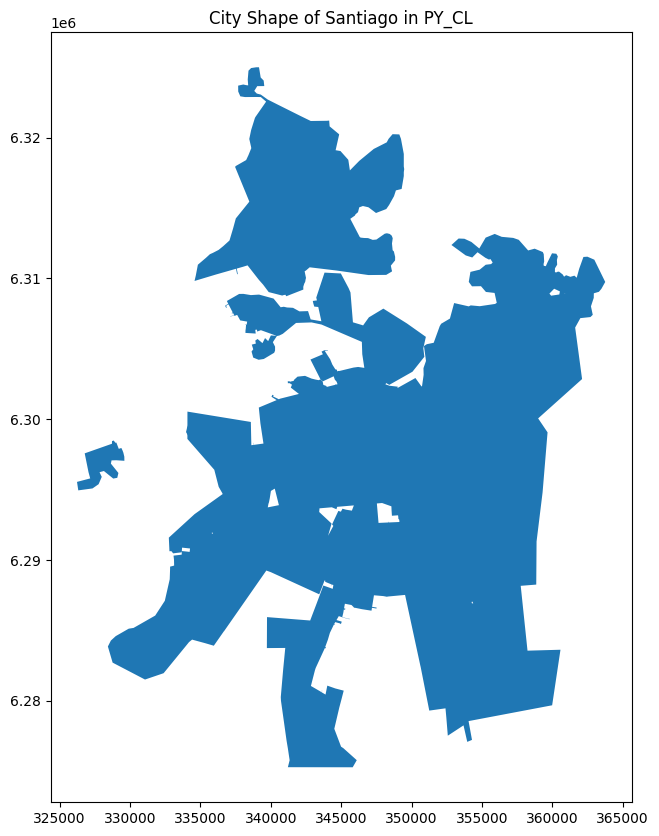

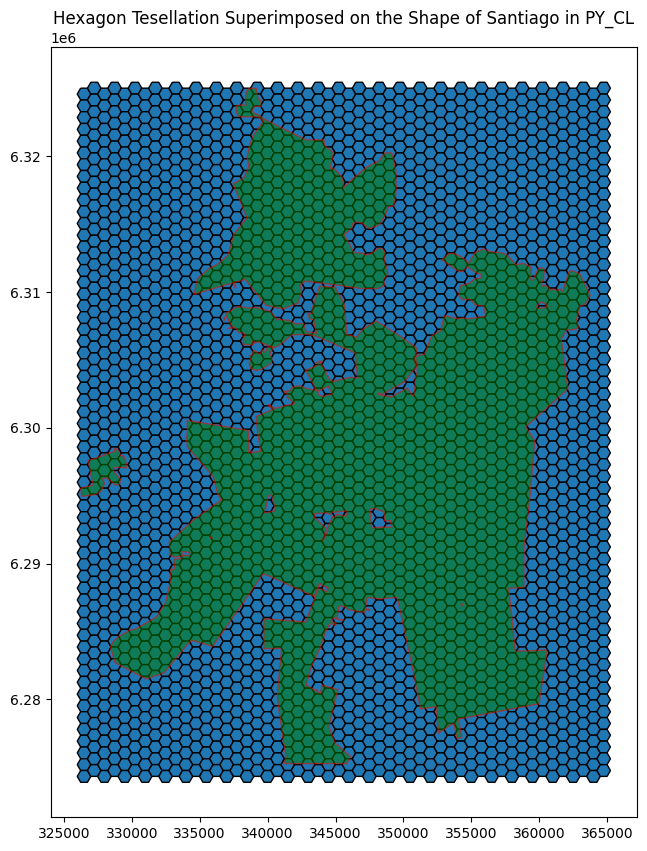

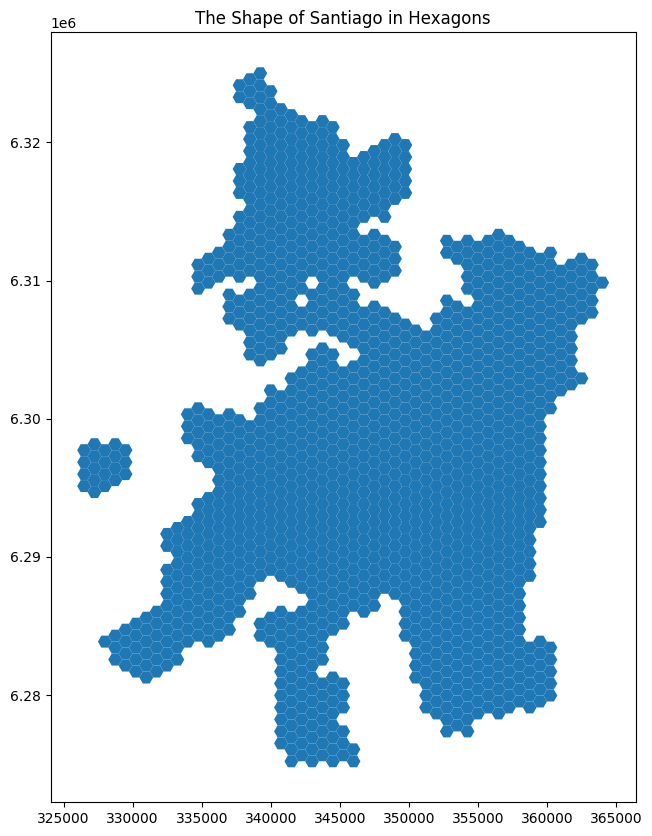

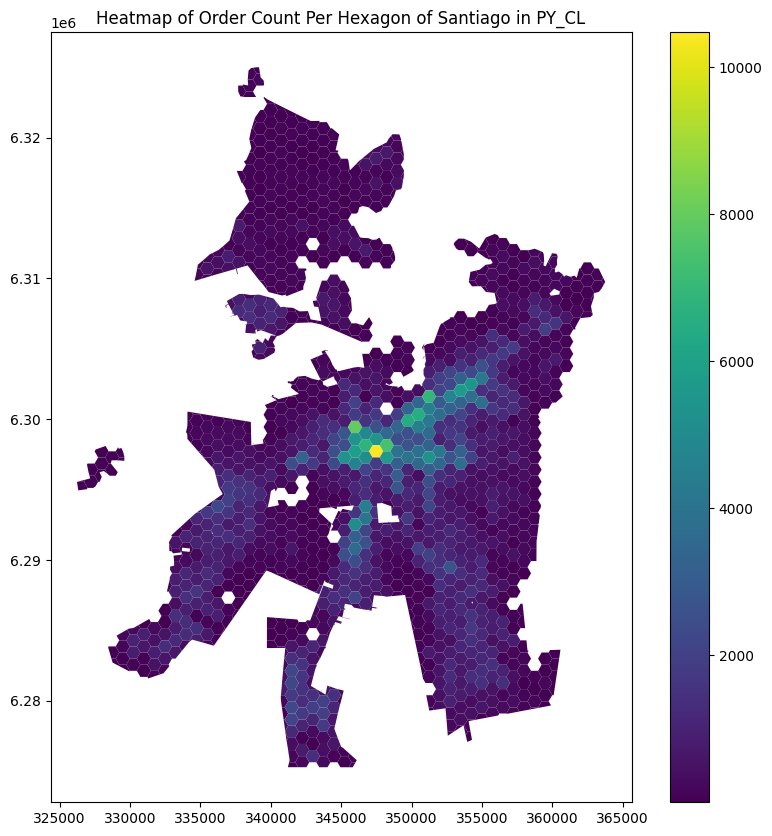

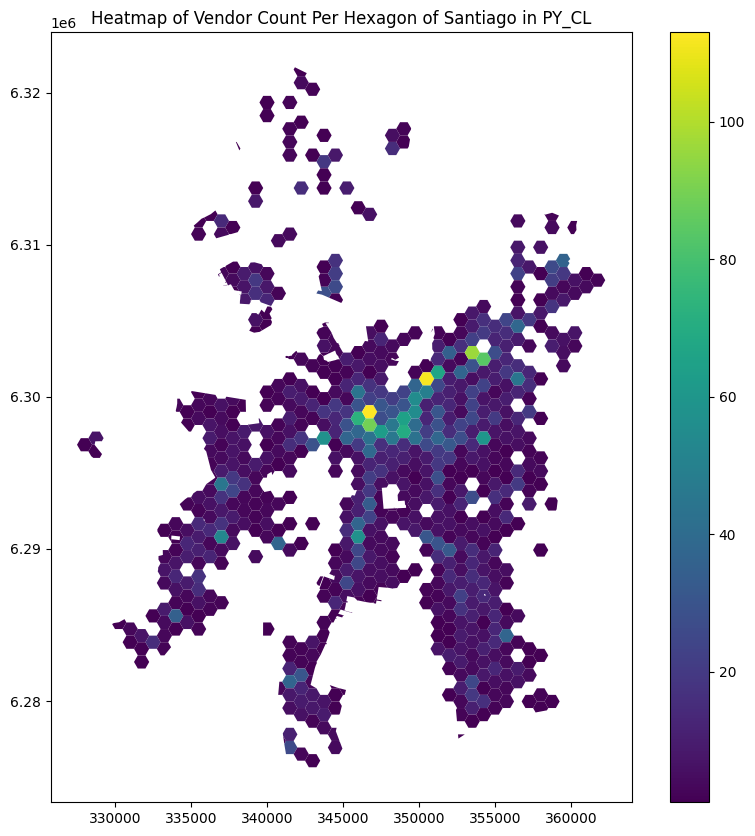

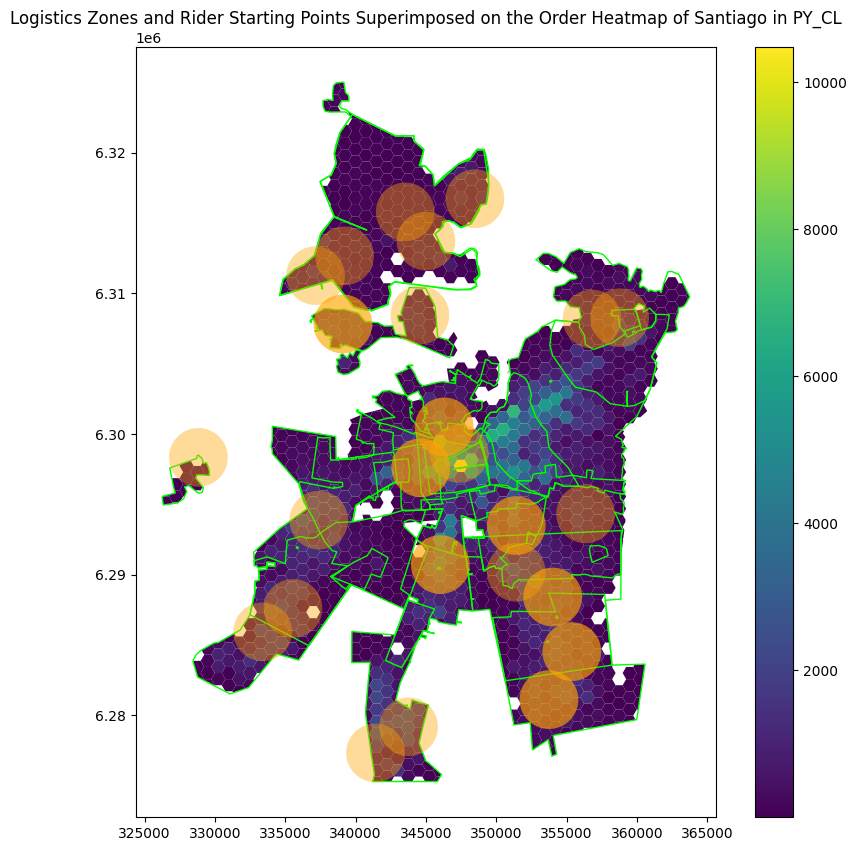

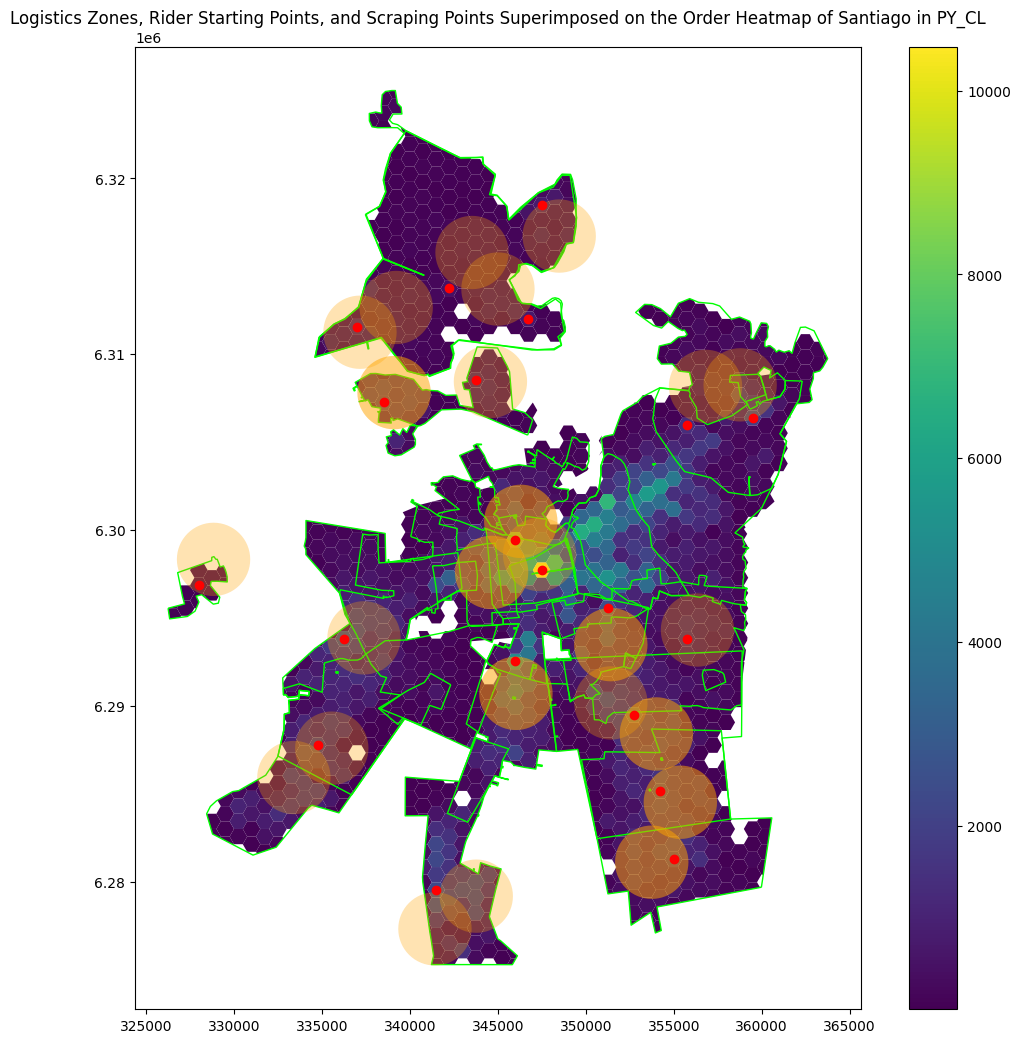

In [13]:
class ScrapingPoints:
    def __init__(self, city_name):
        self.city_name = city_name
        self.shape_city_hex_tes_inter = gpd.GeoDataFrame()
        self.shape_zone_filtered = gpd.GeoDataFrame()
        self.starting_point_shape_filtered = gpd.GeoDataFrame()

    def city_hex_tesellation(self):
        """
        A function to create a tesellation of Hexagons forming the shape of the city
        """
        # Filter shape_city and shape_zone to "city_name"
        shape_city_filtered = shape_city[shape_city["city_name"] == self.city_name]
        self.shape_zone_filtered = shape_zone[shape_zone["city_name"] == self.city_name]
        self.starting_point_shape_filtered = starting_point_shape[(starting_point_shape["city_name"] == self.city_name) & (starting_point_shape["demand_distribution"] >= zone_st_point_order_share)]
        self.starting_point_shape_filtered = self.starting_point_shape_filtered.to_crs(crs_espg_code) # Transform the "starting_point_shape_filtered" GeoDataFrame to the coordinate reference system (CRS) with EPSG code crs_espg_code

        # Plot the shape of the city (solid fill not hexagonal shapes)
        shape_city_filtered.plot(figsize = (10, 10))
        plt.title(f"City Shape of {self.city_name.capitalize()} in {entity_id}")

        ###---------------------###---------------------###

        # Superimpose the Hexagon tesellation on the polygon shape of the city
        # Calculate the limits of the zone to be able to generate the grid
        xmin, ymin, xmax, ymax = shape_city_filtered.total_bounds

        # Add a buffer to dampen possible city growth
        hex_tesellation_layout = hexagon_tesellation(
            xmin=xmin,
            xmax=xmax,
            ymin=ymin,
            ymax=ymax,
            side=hex_radius_tesellation_m,
            epsg=crs_espg_code
        )

        # Superimpose the Hexagon tesellation on the polygon shape of the city
        ax = hex_tesellation_layout.plot(edgecolor = "black", figsize = (10, 10))
        shape_city_filtered.plot(ax = ax, color = "g", edgecolor = "r", alpha = 0.5)
        plt.title(f"Hexagon Tesellation Superimposed on the Shape of {self.city_name.capitalize()} in {entity_id}")

        ###---------------------###---------------------###

        # Cut the Hexagons so they take the shape of the city and plot the hexagons
        # We cut the Hexagons so they take the shape of the city
        shape_city_hex_tes_inter = gpd.overlay(hex_tesellation_layout, shape_city_filtered, how="intersection") # Can also use gpd.sjoin

        # Create a copy of the raw hex_tesellation_layout and filter that copy for the cells that exist in shape_city_hex_tes_inter
        hex_city = hex_tesellation_layout.copy()
        hex_city = hex_city[hex_city.cell.isin(shape_city_hex_tes_inter.cell.values)]

        # Plot the Hexagons that take the shape of the city
        hex_city.plot(figsize = (10, 10))
        plt.title(f"The Shape of {self.city_name.capitalize()} in Hexagons")

        return shape_city_filtered, self.shape_zone_filtered, self.starting_point_shape_filtered, hex_tesellation_layout, shape_city_hex_tes_inter, hex_city

    def heatmaps(self, shape_city_hex_tes_inter, shape_zone_filtered, starting_point_shape_filtered):
        """
        A function to create a heatmap showing the concentration of orders and vendors on a hexagonal, geospatial grid
        """
        # Pull the 95th percentile of dps_travel_time and travel_time_distance_km. This will be the default travel distance radius of the zone's starting points for assigning riders to a shift
        df_st_point_radius = client.query(f"""
            SELECT DISTINCT
                entity_id,
                ROUND(PERCENTILE_CONT(dps_travel_time, 0.95) OVER (PARTITION BY entity_id), 2) AS travel_time_95_ntile,
                ROUND(PERCENTILE_CONT(travel_time_distance_km * 1000, 0.95) OVER (PARTITION BY entity_id), 2) AS travel_dist_95_ntile,
                ROUND(PERCENTILE_CONT(travel_time_distance_km * 1000, 0.95) OVER (PARTITION BY entity_id) / 2, 2) AS travel_dist_radius,
            FROM `fulfillment-dwh-production.cl.dps_sessions_mapped_to_orders_v2`
            WHERE TRUE
                AND entity_id='{entity_id}'
                AND created_date_local BETWEEN {lookback_period}
                AND is_sent
        """).result().to_dataframe()

        travel_dist_radius = df_st_point_radius["travel_dist_radius"][0]

        # Pull historical data over the past 4 weeks to get the customer location and vendor location coordinates
        geo_order_partner = client.query (f"""
        WITH geo AS (
            SELECT
                entity_id,
                perseus_client_id,
                platform_order_code,
                vendor_id,
                customer_location,
                vendor_location
            FROM `fulfillment-dwh-production.cl.dps_sessions_mapped_to_orders_v2` 
            WHERE TRUE
                AND created_date BETWEEN {lookback_period}
                AND entity_id = '{entity_id}'
                AND city_name = '{self.city_name}'
        )

        SELECT
            "orders" AS kind,
            platform_order_code AS kind_id,
            customer_location AS location,
        FROM geo

        UNION ALL

        SELECT 
            "vendors" AS kind,
            vendor_id AS kind_id,
            vendor_location AS location,
        FROM geo
        QUALIFY ROW_NUMBER() OVER (PARTITION BY kind_id ORDER BY 1) = 1 -- Necessary filter to get one record per vendor
        """).to_geodataframe()

        # Transform the "geo_order_partner" GeoDataFrame to the coordinate reference system (CRS) with EPSG code crs_espg_code
        geo_order_partner = geo_order_partner.to_crs(crs_espg_code)

        # Join geo_order_partner to shape_city_hex_tes_inter
        # "geo_order_partner" contains the customer and vendor location coordinates of all orders in the past 4 weeks. "shape_city_hex_tes_inter" contains the hexagonal layout of the city of interest 
        dfs_join = gpd.sjoin(left_df=shape_city_hex_tes_inter, right_df=geo_order_partner, how="inner").reset_index(drop=True)

        # Create a pivot table where the index is the cell/hexagon number and the columns are the unique order count and vendor count in each cell 
        df_pivot = pd.pivot_table(dfs_join, index='cell', columns='kind', aggfunc={'kind_id': lambda x: len(x.unique())})
        df_pivot.columns = df_pivot.columns.droplevel()

        # Join the number of orders and vendors per Hexagon to shape_city_hex_tes_inter
        df_city_heatmap = shape_city_hex_tes_inter.merge(df_pivot, how='left', on='cell')

        # Plot a heat map of orders per Hexagon
        df_city_heatmap.plot("orders", figsize = (10, 10), legend=True)
        plt.title(f"Heatmap of Order Count Per Hexagon of {self.city_name} in {entity_id}")

        # Plot a heat map of vendors per Hexagon
        df_city_heatmap.plot("vendors", figsize = (10, 10), legend=True)
        plt.title(f"Heatmap of Vendor Count Per Hexagon of {self.city_name} in {entity_id}")

        ###---------------------###---------------------###

        # Add information on logistics zones to df_city_heatmap
        # Join shape zone on df_city_heatmap
        df_zone_heatmap = df_city_heatmap.sjoin(shape_zone_filtered[["zone_name", "zone_id", "zone_shape"]], how="inner", predicate="intersects")

        # Display the data sorted in descending order of orders and drop the column that gets produced from the join "index_right"
        df_zone_heatmap = df_zone_heatmap.sort_values("orders", axis=0, ascending=False).reset_index(drop=True)
        df_zone_heatmap = df_zone_heatmap.drop("index_right", axis=1)

        # Superimpose the logistics zones and starting points on top the city's hexagons
        # Plot the orders heatmap
        ax = df_city_heatmap.plot("orders", figsize = (10, 10), legend=True)
        
        # Superimpose the logistics zones
        ax2 = shape_zone_filtered.plot(ax=ax, color="None", edgecolor="lime", alpha=1)
        
        # Superimpose the starting points
        starting_point_shape_filtered[["sp_name", "sp_id", "sp_centroid", "demand_distribution"]].buffer(travel_dist_radius).plot(figsize = (10, 10), color="orange", ax=ax2, alpha=0.4)
        
        # Add the title
        plt.title(f"Logistics Zones and Rider Starting Points Superimposed on the Order Heatmap of {self.city_name} in {entity_id}")

        return geo_order_partner, df_city_heatmap, df_zone_heatmap, travel_dist_radius

    def scraping_points_df_generator(self, starting_point_shape_filtered, travel_dist_radius, df_city_heatmap, df_zone_heatmap, shape_zone_filtered):
        """
        A function to generate the final data frame that containts the scraping points and plot the logistics zones, rider starting points, and scraping points
        superimposed on the order heatmap of the city 
        """
        # Add a buffer to the geometry field in "starting_point_shape_filtered," which is sp_centroid. This creates a circle with radius "travel_dist_radius"
        starting_point_shape_filtered["radius_max_travel_dist"] = starting_point_shape_filtered.buffer(travel_dist_radius)

        # Join "df_zone_heatmap" with "starting_point_shape_filtered" to filter out the hexagons that are NOT covered by the starting zone circles
        df_hex_st_zone_circles = gpd.sjoin(
            left_df=df_zone_heatmap,
            right_df=starting_point_shape_filtered[["sp_name", "sp_id", "demand_distribution", "radius_max_travel_dist"]].set_geometry('radius_max_travel_dist'),
            how="inner",
            predicate="intersects"
        ).drop("index_right", axis=1)

        # Get the cell indices with the most orders per staring zone and search for those indices in the dataframe
        df_highest_orders_per_st_zone = df_hex_st_zone_circles[["cell", "entity_id", "city_name", "city_id", "orders"]]
        df_highest_orders_per_st_zone = df_highest_orders_per_st_zone.loc[df_hex_st_zone_circles.groupby("sp_id")['orders'].idxmax()]

        # Drop the index duplicates and keep the first one, then reset the index
        df_highest_orders_per_st_zone = df_highest_orders_per_st_zone.drop_duplicates().reset_index(drop=True)

        # Join the cell with the shape of the hegaxon to get the hexagons containing the scraping points. The centroids of the hexagons are the latitude and longitude of the scraping points
        df_scraping_hex = df_hex_st_zone_circles[["cell", "geometry"]].merge(df_highest_orders_per_st_zone, how='right', on='cell').drop_duplicates("cell").reset_index(drop=True)
        df_scraping_hex.rename_geometry(col="hexagon_geometry", inplace=True)

        # Find the centeroids of the hexagon. Those will be the scraping points
        df_scraping_hex["scraping_point_hex_centroid"] = df_scraping_hex.centroid

        # Define the scraping point as the primary geometry of the data frame
        df_scraping_hex = df_scraping_hex.set_geometry("scraping_point_hex_centroid")

        # Join df_zone_heatmap, which contains data on zones, to df_scraping_hex, which contains the scraping points
        df_scraping_hex_plus_zone_data = gpd.sjoin(
            left_df=df_zone_heatmap,
            right_df=df_scraping_hex[["entity_id", "scraping_point_hex_centroid"]],
            how="right",
            predicate="contains"
        ).dropna().drop(["index_left", "entity_id_right"], axis=1)

        # Create an array that combines the logistics zones
        df_zone_list = df_scraping_hex_plus_zone_data.groupby("cell", as_index = False)["zone_name"].apply(lambda x: list(x))

        # Create the final data frame that has the scraping points
        df_final_scraping_points = pd.merge(
            left=df_scraping_hex,
            right=df_zone_list,
            on="cell",
            how="left"
        )

        # Get the latitude and longitude of each scraping point
        df_final_scraping_points = df_final_scraping_points.assign(
            longitude=df_final_scraping_points["scraping_point_hex_centroid"].x,
            latitude=df_final_scraping_points["scraping_point_hex_centroid"].y,
        )

        # Plot the scraping points
        ax1 = df_city_heatmap.plot("orders", figsize = (12.5, 12.5), legend=True)

        # Superimpose the logistics zones
        ax2 = shape_zone_filtered.plot(ax=ax1, color="None", edgecolor="lime", alpha=1)

        # Superimpose the starting points
        ax3 = starting_point_shape_filtered[["sp_name", "sp_id", "sp_centroid", "demand_distribution"]].buffer(travel_dist_radius).plot(figsize = (12.5, 12.5), color="orange", ax=ax2, alpha=0.3)

        # Superimpose the scraping points
        df_final_scraping_points.plot(ax=ax3, figsize=(12.5, 12.5), color='r', alpha=1)

        # Print a message saying how many scraping points wer have per city
        print(f"The number of scraping points we have in {city_name}, {entity_id} is: {df_final_scraping_points['scraping_point_hex_centroid'].count()}")

        # Add the title
        plt.title(f"Logistics Zones, Rider Starting Points, and Scraping Points Superimposed on the Order Heatmap of {city_name} in {entity_id}")

    def execute_functions(self):
        shape_city_filtered, shape_zone_filtered, starting_point_shape_filtered, hex_tesellation_layout, shape_city_hex_tes_inter, hex_city = self.city_hex_tesellation()
        geo_order_partner, df_city_heatmap, df_zone_heatmap, travel_dist_radius = self.heatmaps(
            shape_city_hex_tes_inter=shape_city_hex_tes_inter,
            shape_zone_filtered=shape_zone_filtered,
            starting_point_shape_filtered=starting_point_shape_filtered
        )
        self.scraping_points_df_generator(
            starting_point_shape_filtered=starting_point_shape_filtered,
            travel_dist_radius=travel_dist_radius,
            df_city_heatmap=df_city_heatmap,
            df_zone_heatmap=df_zone_heatmap,
            shape_zone_filtered=shape_zone_filtered
        )

# Instantiate the class and call the functions
sp = ScrapingPoints(city_name=city_name)
sp.execute_functions()